# Autoencoders, tSNE and the fashion_mnist dataset


An autoencoder is neural network with an output layer the same size as the input layer. The input image is itself used as a label. This is sometimes called self-supervised learning. (Not unsupervised.) In the middle of the network the layer size is reduced to a pinch point where the images must be encoded into a lower-dimensional *latent space*.

In this notebook I will follow sections of the following keras blog https://blog.keras.io/building-autoencoders-in-keras.html but use the fashion_mnist dataset instead of handwritten digits. (This second article is also informative https://towardsdatascience.com/generating-images-with-autoencoders-77fd3a8dd368
)

## The fashion_mnist dataset

From the Keras website:   

*Dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images. This dataset can be used as a drop-in replacement for MNIST. The class labels are:*

Label	Description  
0	T-shirt/top  
1	Trouser  
2	Pullover  
3	Dress  
4	Coat  
5	Sandal  
6	Shirt  
7	Sneaker  
8	Bag  
9	Ankle boot   

Let's take a look

In [1]:
# dependencies
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import fashion_mnist  # keras comes with the dataset preinstalled
((X_train, Y_train), (X_test, Y_test)) = fashion_mnist.load_data()

#from keras.datasets import mnist         #  this is the handwritten digits dataset
#((X_train, Y_train), (X_test, Y_test)) = mnist.load_data()

from keras.layers import Input, Dense
from keras.models import Model

# helper function to decode the numerical labels from the fashion_mnist dataset
def label_name(n):
    labels = ['T-shirt/top','Trouser','Pullover','Dress','Coat',
              'Sandal','Shirt','Sneaker','Bag','Ankle boot']
    return labels[n]

Using TensorFlow backend.


In [2]:
# prepare data (reshape, normalise and float)
X_train = X_train.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0
X_train = X_train.reshape((len(X_train), 784))    # 784 = 28x28
X_test = X_test.reshape((len(X_test), 784))

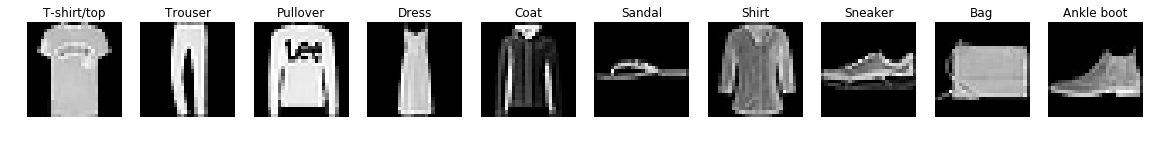

In [3]:
plt.figure(figsize=(20, 4))

first_of_each_i = []

# search through the dataset and plot the first example of each clothing item
# for each clothing item
for item_i in range(10):
    ax = plt.subplot2grid((1,10), (0, item_i))
    
    # find first clothing item of type in training data
    n = np.where(Y_test == item_i)[0][0]
    first_of_each_i.append(n)
    
    ax.imshow(X_test[n].reshape((28,28)), cmap="gray")
    ax.set_title(label_name(Y_test[n]))
    ax.axis('off')
    
plt.show()

So here we can see a sample of the images stored in the dataset.

## Autoencoder 1

For my first autoencoder I want to squeeze the latent dimension size down to 2. This is is quite a restriction on the originally 784 dimensional images. As the latent space is 2D I can visualize where each image is encoded to in the latent space. Later I will try a different technique for visualising latent spaces (tSNE).

For this autoencoder I am using simple fully-connected layers.

In [35]:
# construct
input_img = Input(shape=(784,))
encoding_1 = Dense(128, activation='relu')(input_img)
encoding_2 = Dense(32, activation='relu')(encoding_1)
encoding_3 = Dense(16, activation='relu')(encoding_2)
encoding_4 = Dense(2, activation='relu')(encoding_3)

decoding_1 = Dense(16, activation='relu')(encoding_4)
decoding_2 = Dense(32, activation='relu')(decoding_1)
decoding_3 = Dense(128, activation='relu')(decoding_2)
decoding_4 = Dense(784, activation='sigmoid')(decoding_3)

# autoencoder
autoencoder_1 = Model(input_img, decoding_4)

# encoder
encoder_1 = Model(input_img, encoding_4)

# decoder
encoded_input = Input(shape=(2,))
decoder_l1 = autoencoder_1.layers[-4](encoded_input)
decoder_l2 = autoencoder_1.layers[-3](decoder_l1)
decoder_l3 = autoencoder_1.layers[-2](decoder_l2)
decoder_l4 = autoencoder_1.layers[-1](decoder_l3)

decoder_1 = Model(encoded_input, decoder_l4)

# compile
autoencoder_1.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder_1.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 784)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 128)               100480    
_________________________________________________________________
dense_36 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_37 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_38 (Dense)             (None, 2)                 34        
_________________________________________________________________
dense_39 (Dense)             (None, 16)                48        
_________________________________________________________________
dense_40 (Dense)             (None, 32)                544       
__________

In [36]:
# train the autoencoder
autoencoder_1.fit(X_train, X_train,
                epochs=20,
                batch_size=256,
                shuffle=True,
                validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 77us/step - loss: 0.6705 - val_loss: 0.5695
Epoch 2/20
60000/60000 [==============================] - 3s 56us/step - loss: 0.4731 - val_loss: 0.4253
Epoch 3/20
60000/60000 [==============================] - 3s 56us/step - loss: 0.4105 - val_loss: 0.3985
Epoch 4/20
60000/60000 [==============================] - 3s 56us/step - loss: 0.3869 - val_loss: 0.3809
Epoch 5/20
60000/60000 [==============================] - 3s 55us/step - loss: 0.3796 - val_loss: 0.3769
Epoch 6/20
60000/60000 [==============================] - 3s 56us/step - loss: 0.3747 - val_loss: 0.3800
Epoch 7/20
60000/60000 [==============================] - 3s 55us/step - loss: 0.3701 - val_loss: 0.3747
Epoch 8/20
60000/60000 [==============================] - 4s 60us/step - loss: 0.3654 - val_loss: 0.3637
Epoch 9/20
60000/60000 [==============================] - 4s 69us/step - loss: 0.3618 - val_loss: 0.3606
Epoch

The encoder now reduces our 28x28 images to a 2D array. The validation loss (the loss calculated on the holdout test set) is ~0.35 after 20 training epochs.

As the latent space is 2D we can plot it directly.

In [40]:
# plotting function. takes data and scatter plots with the class label as the marker. See below for result
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    
    plt.figure(figsize=(20, 20))
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(label_name(y[i])),
                 color=plt.cm.Set1(y[i]),
                 fontdict={'weight': 'bold', 'size': 9})
            
   # plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

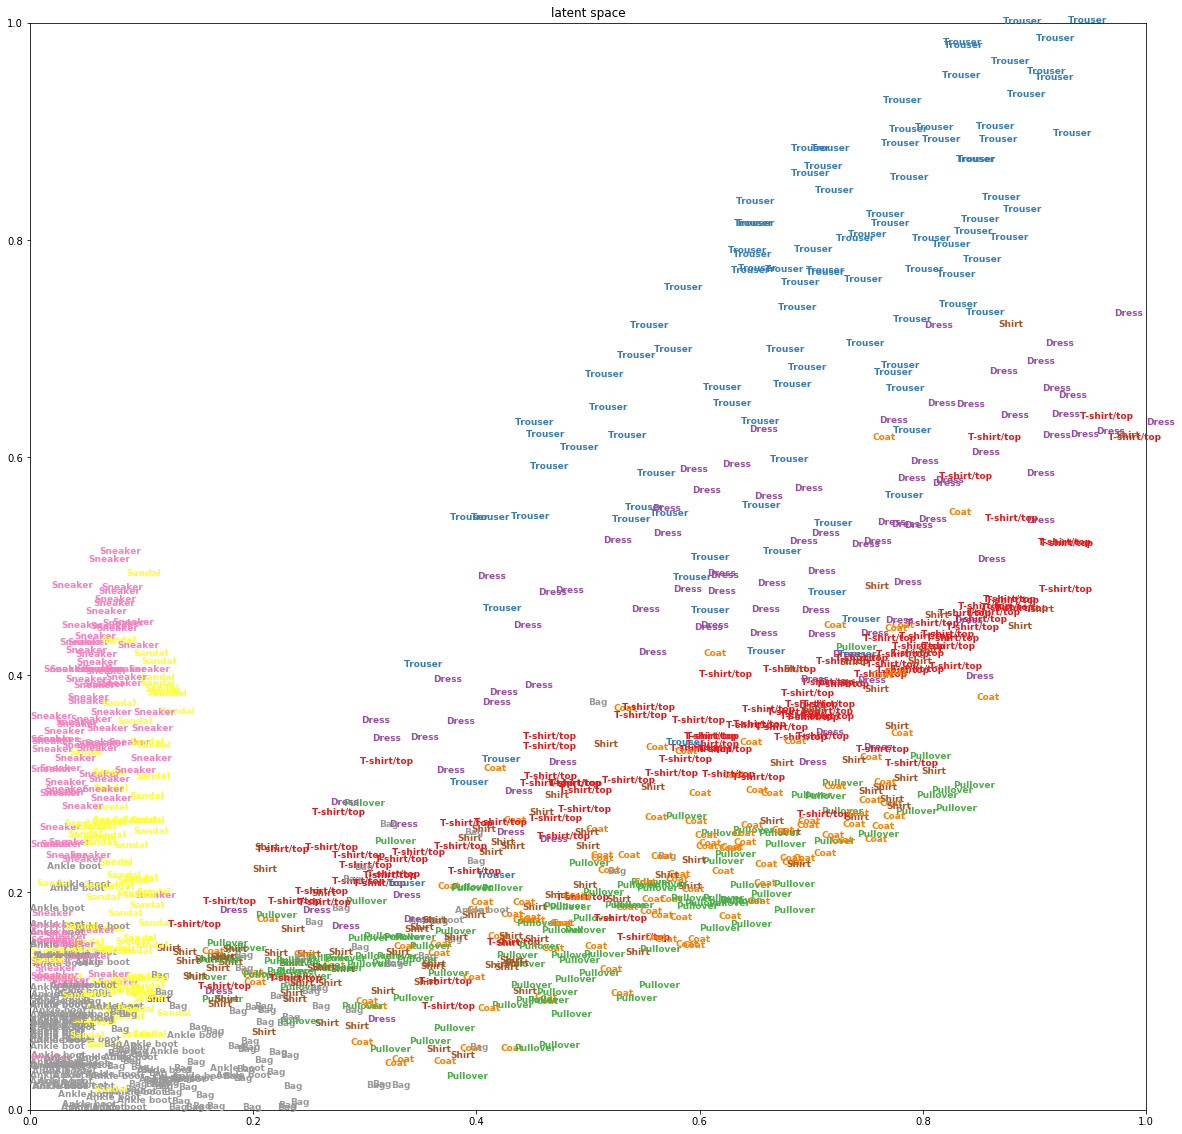

In [41]:
X_latent = encoder_1.predict(X_test[:1000])
y = Y_test[:1000]
plot_embedding(X_latent, "latent space")

In the 2D latent space we see that the different classes are collected in clusters. However the clusters of different classes overlap. For vizualisition purposes it would be useful to if the different clusters were separated well. This provides the motivation to use a method like tSNE (t-distributed stochastic neighbor embedding) - a dimension reduction technique that embeds similiar objects close to each other and dissimiliar objects far from each other. i.e. it creates a 2 or 3D embedding with visibily separate clusters. 

First let's visualise the 2D encoding and reconstructed images from our autoencoder:

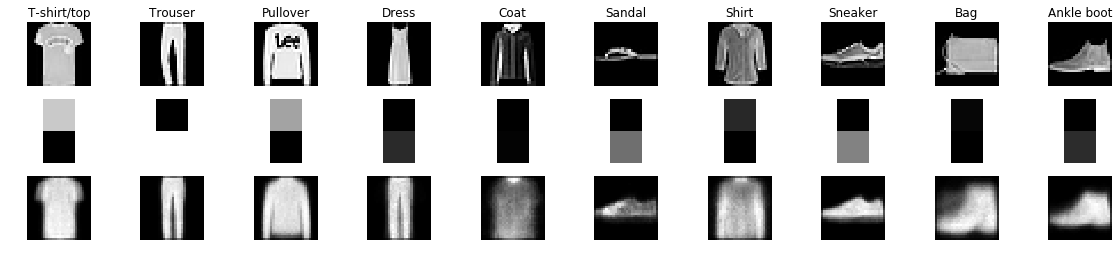

In [54]:
# visualise reconstructed inputs and encoded representations
n = 10
encoded_imgs = encoder_1.predict(X_test[first_of_each_i])
decoded_imgs = decoder_1.predict(encoded_imgs)

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test[first_of_each_i[i]].reshape(28, 28))
    plt.gray()
    ax.set_title(label_name(Y_test[first_of_each_i[i]]))
    ax.axis('off')
    
    # plot encoded version
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape((2,1)), vmax = 41)   # vmax adjusts normalisation in imshow. 
    plt.gray()
    ax.axis('off')
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.axis('off')
    
plt.show()

Here we can see how the autoencoder first decodes the images and the decodes them. We can see that the Bag and Ankle Boot have similar encodings. The decoding of the Bag then produces what looks like an Ankle Boot. This is reflected in the visualisation above where Ankle Boots and Bags appear in the same region.


## Autoencoder 2

To reduce the loss of the autoencoder I will increase the size of the latent dimension. i.e. the encoded layer will have more neurons. The problem with our first autencoder is that it has to sacrifice too much information to encode the images. With a larger latent space more information can be retained and this should improve the reconstruction. 

We will use a single fully-connected layer as encoder and decoder. These have 784 neurons (to accept a flattened version of each image). The single hidden layer has 32 neurons.

In [57]:
# size of encoded representation (latent space dimension)
encoding_dim = 32

# input image place holder
input_img = Input(shape=(784,))
# encoding layer
encoded = Dense(encoding_dim, activation='relu')(input_img)
# decoding layer
decoded = Dense(784, activation='sigmoid')(encoded)

# create autoencoder model
autoencoder_2 = Model(input_img, decoded)

In [58]:
# create separate encoder and decoder models. 
# these are used to encode and decode images. 
# we only train the autoencoder then can use the encoder and decoder to explore the latent space.

# encoder
encoder_2 = Model(input_img, encoded)

# decoder
# placeholder for encoded input
encoded_input = Input(shape=(encoding_dim,))
# last layer
decoder_layer = autoencoder_2.layers[-1]
# create model
decoder_2 = Model(encoded_input, decoder_layer(encoded_input))

In [59]:
# compile autoencoder
autoencoder_2.compile(optimizer='adadelta', loss='binary_crossentropy')

In [60]:
# train autoencoder
autoencoder_2.fit(X_train, X_train, epochs=50, 
                batch_size = 256, shuffle = True,
               validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 48us/step - loss: 0.5284 - val_loss: 0.4557
Epoch 2/50
60000/60000 [==============================] - 2s 37us/step - loss: 0.4238 - val_loss: 0.4040
Epoch 3/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.3923 - val_loss: 0.3842
Epoch 4/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.3749 - val_loss: 0.3693
Epoch 5/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.3614 - val_loss: 0.3574
Epoch 6/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.3507 - val_loss: 0.3481
Epoch 7/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.3423 - val_loss: 0.3406
Epoch 8/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.3357 - val_loss: 0.3348
Epoch 9/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.3305 - val_loss: 0.3301
Epoch

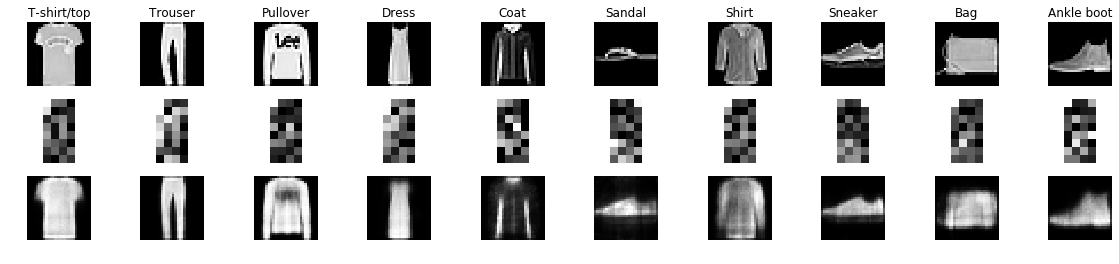

In [61]:
# visualise inputs, encoded representations and reconstructed outputs 
n = 10  # 10 classes. use same set as plotted above
encoded_imgs = encoder.predict(X_test[first_of_each_i])  # this creaetes encoded images
decoded_imgs = decoder.predict(encoded_imgs)             # this decodes the encoded images

plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(X_test[first_of_each_i[i]].reshape(28, 28))
    plt.gray()
    ax.set_title(label_name(Y_test[first_of_each_i[i]]))
    ax.axis('off')
    
    # plot encoded version
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(encoded_imgs[i].reshape(8, 4))
    plt.gray()
    ax.axis('off')
    
    # display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.axis('off')
    
plt.show()

The second autoencoder does a better job of reconstructing the images. The validation loss after 50 epochs was ~ 0.3 - a reduction of 15%. One way to improve the autoencoder further would be to use a convolutional network.

We see now that the Ankle Boot and Bag have different encodings so the Bag is able to be reconstructed better. Looking at the Pullover we see that detail of the branding has started to be captured where it wasnt before.

## t-SNE

Because the latent space is now 32D we can't visualise it directly. But we can use tSNE. Here we use t-SNE to view clusters in the latent space. (Code edited from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html#sphx-glr-auto-examples-manifold-plot-lle-digits-py.) t-SNE performs a dimensionality reduction from the 32-D latent space to a 2-D space so that it can be visualised. 

In [64]:
from sklearn import manifold
from time import time
from matplotlib import offsetbox

n_sample = 1000

# only look at a few of the classes
selection_i = np.where((Y_test == 0)|(Y_test == 1)|(Y_test == 7)|(Y_test == 8)|(Y_test == 9))
X_selected = X_test[selection_i]
Y_selected = Y_test[selection_i]

# calculate t_SNE from latent space
X = encoder.predict(X_selected)
y = Y_selected
n_samples, n_features = X.shape

# do tSNE
tsne = manifold.TSNE(n_components=2, init='pca', random_state=42)  
t0 = time()
X_tsne = tsne.fit_transform(X)

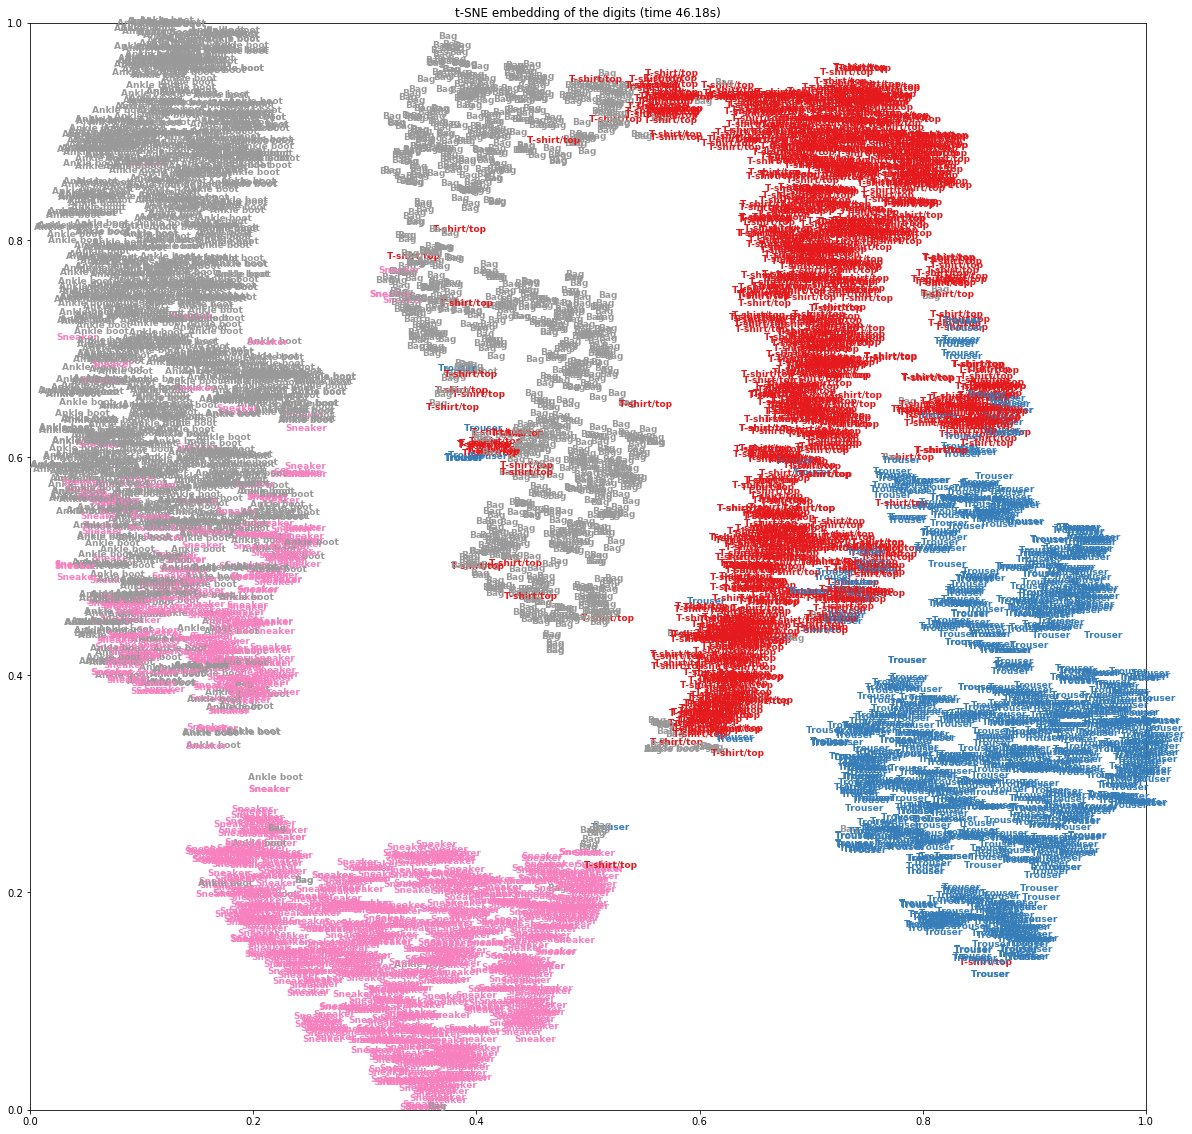

In [65]:
# plot results using our plotting function
plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

Using tSNE we find obtain a latent space visualisation with much better clustering. It is a good tool for prompting some questions. E.g. It looks like there are a portion of the Sneakers that look more like ankle boots. Perhaps high-top trainers?

However care must be taken with tSNE clustering as it can produce clusters where in fact none-exist. From wikipedia:  
*While t-SNE plots often seem to display clusters, the visual clusters can be influenced strongly by the chosen parameterization and therefore a good understanding of the parameters for t-SNE is necessary. Such "clusters" can be shown to even appear in non-clustered data,[https://stats.stackexchange.com/questions/263539/clustering-on-the-output-of-t-sne/264647#264647] and thus may be false findings.*

A different method to obtain a 2D latent space with structural meaning is variational autoencoders. 

## Summary

In this notebook I have trained two autoencoders on the fashion_mnist dataset. The autoencoder with a latent space dimension of 2 could be visualised directly but we saw overlapping clusters. Changing to a latent space dimension of 32 yeilded a reduction in the validation loss of 15%. We used tSNE to visualise the 32D latent space and observed the different fashion items were separated into distinct clusters. 